In [1]:
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

2025-12-16 16:36:14.697526: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-16 16:36:14.713811: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765870574.725710   68404 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765870574.729497   68404 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-16 16:36:14.744315: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
# 실행마다 동일한 결과를 얻기 위해 케라스에 랜덤 시드를 사용하고 텐서플로 연산을 결정적으로 만듬
keras.utils.set_random_seed(42)
tf.random.set_seed(42)
tf.config.experimental.enable_op_determinism()

In [3]:
# 데이터 셋
(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()
# 스케일링
train_scaled = train_input.reshape(-1, 28, 28, 1) / 255.0
# 훈련 > 훈련 & 검증 세트
train_scaled, val_scaled, train_target, val_target = train_test_split(train_scaled, train_target, test_size=0.2, random_state=42)

In [4]:
# (28, 28)입력 배열 >> (3,3) relu 모델 필터 32개, 입력 배열과 같은 크기의 출력 배열 >> (2,2)배열로 최댓값 풀링
model = keras.Sequential()
model.add(keras.layers.Input(shape=(28,28,1)))
model.add(keras.layers.Conv2D(32, kernel_size=3, activation='relu', padding='same'))
model.add(keras.layers.MaxPooling2D(2))

# (3,3) relu 모델 필터 64개, 입력 배열과 같은 크기의 출력 배열 >> (2,2)배열로 최댓값 풀링
model.add(keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
model.add(keras.layers.MaxPooling2D(2))

model.add(keras.layers.Flatten()) # 특성맵 >> flatten 층
model.add(keras.layers.Dense(100, activation='relu')) # 100개 뉴런 relu 모델 은닉층
model.add(keras.layers.Dropout(0.4)) # 은닉층 40% dropout으로 과적합 방지
model.add(keras.layers.Dense(10, activation='softmax')) # 10개 뉴런 softmax 모델 출력층

model.summary()

W0000 00:00:1765870583.110682   68404 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │       313,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 333,526 (1.27 MB)

 Trainable params: 333,526 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

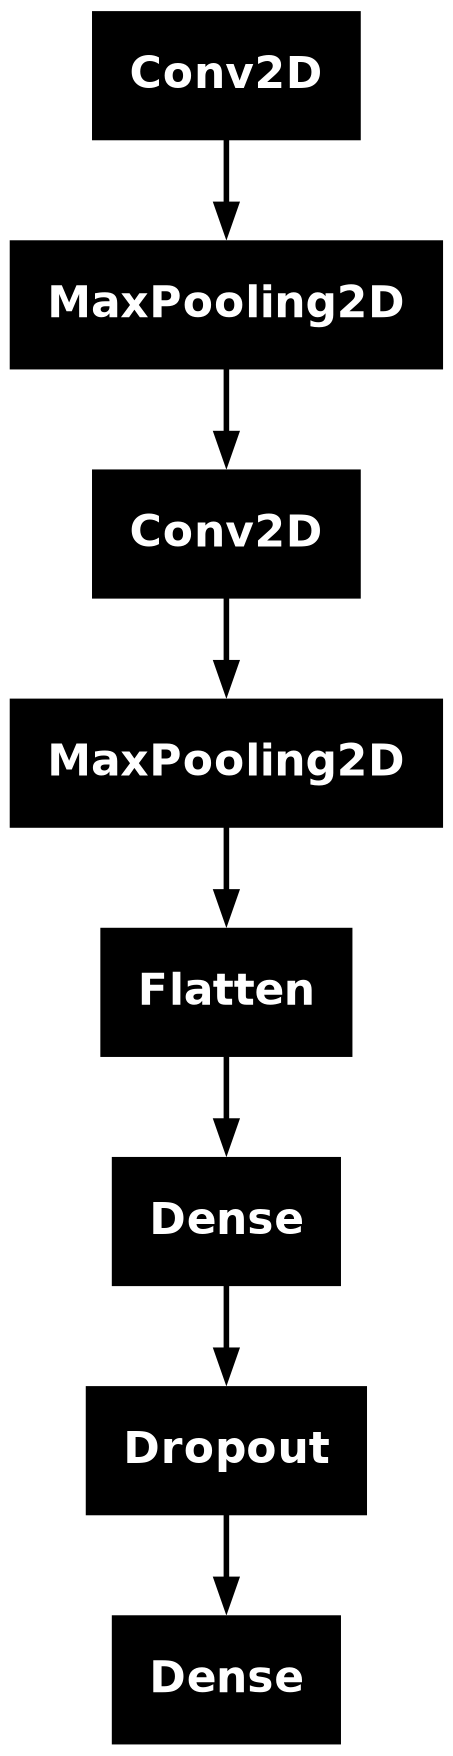

In [11]:
# 층별 모델 확인
keras.utils.plot_model(model)

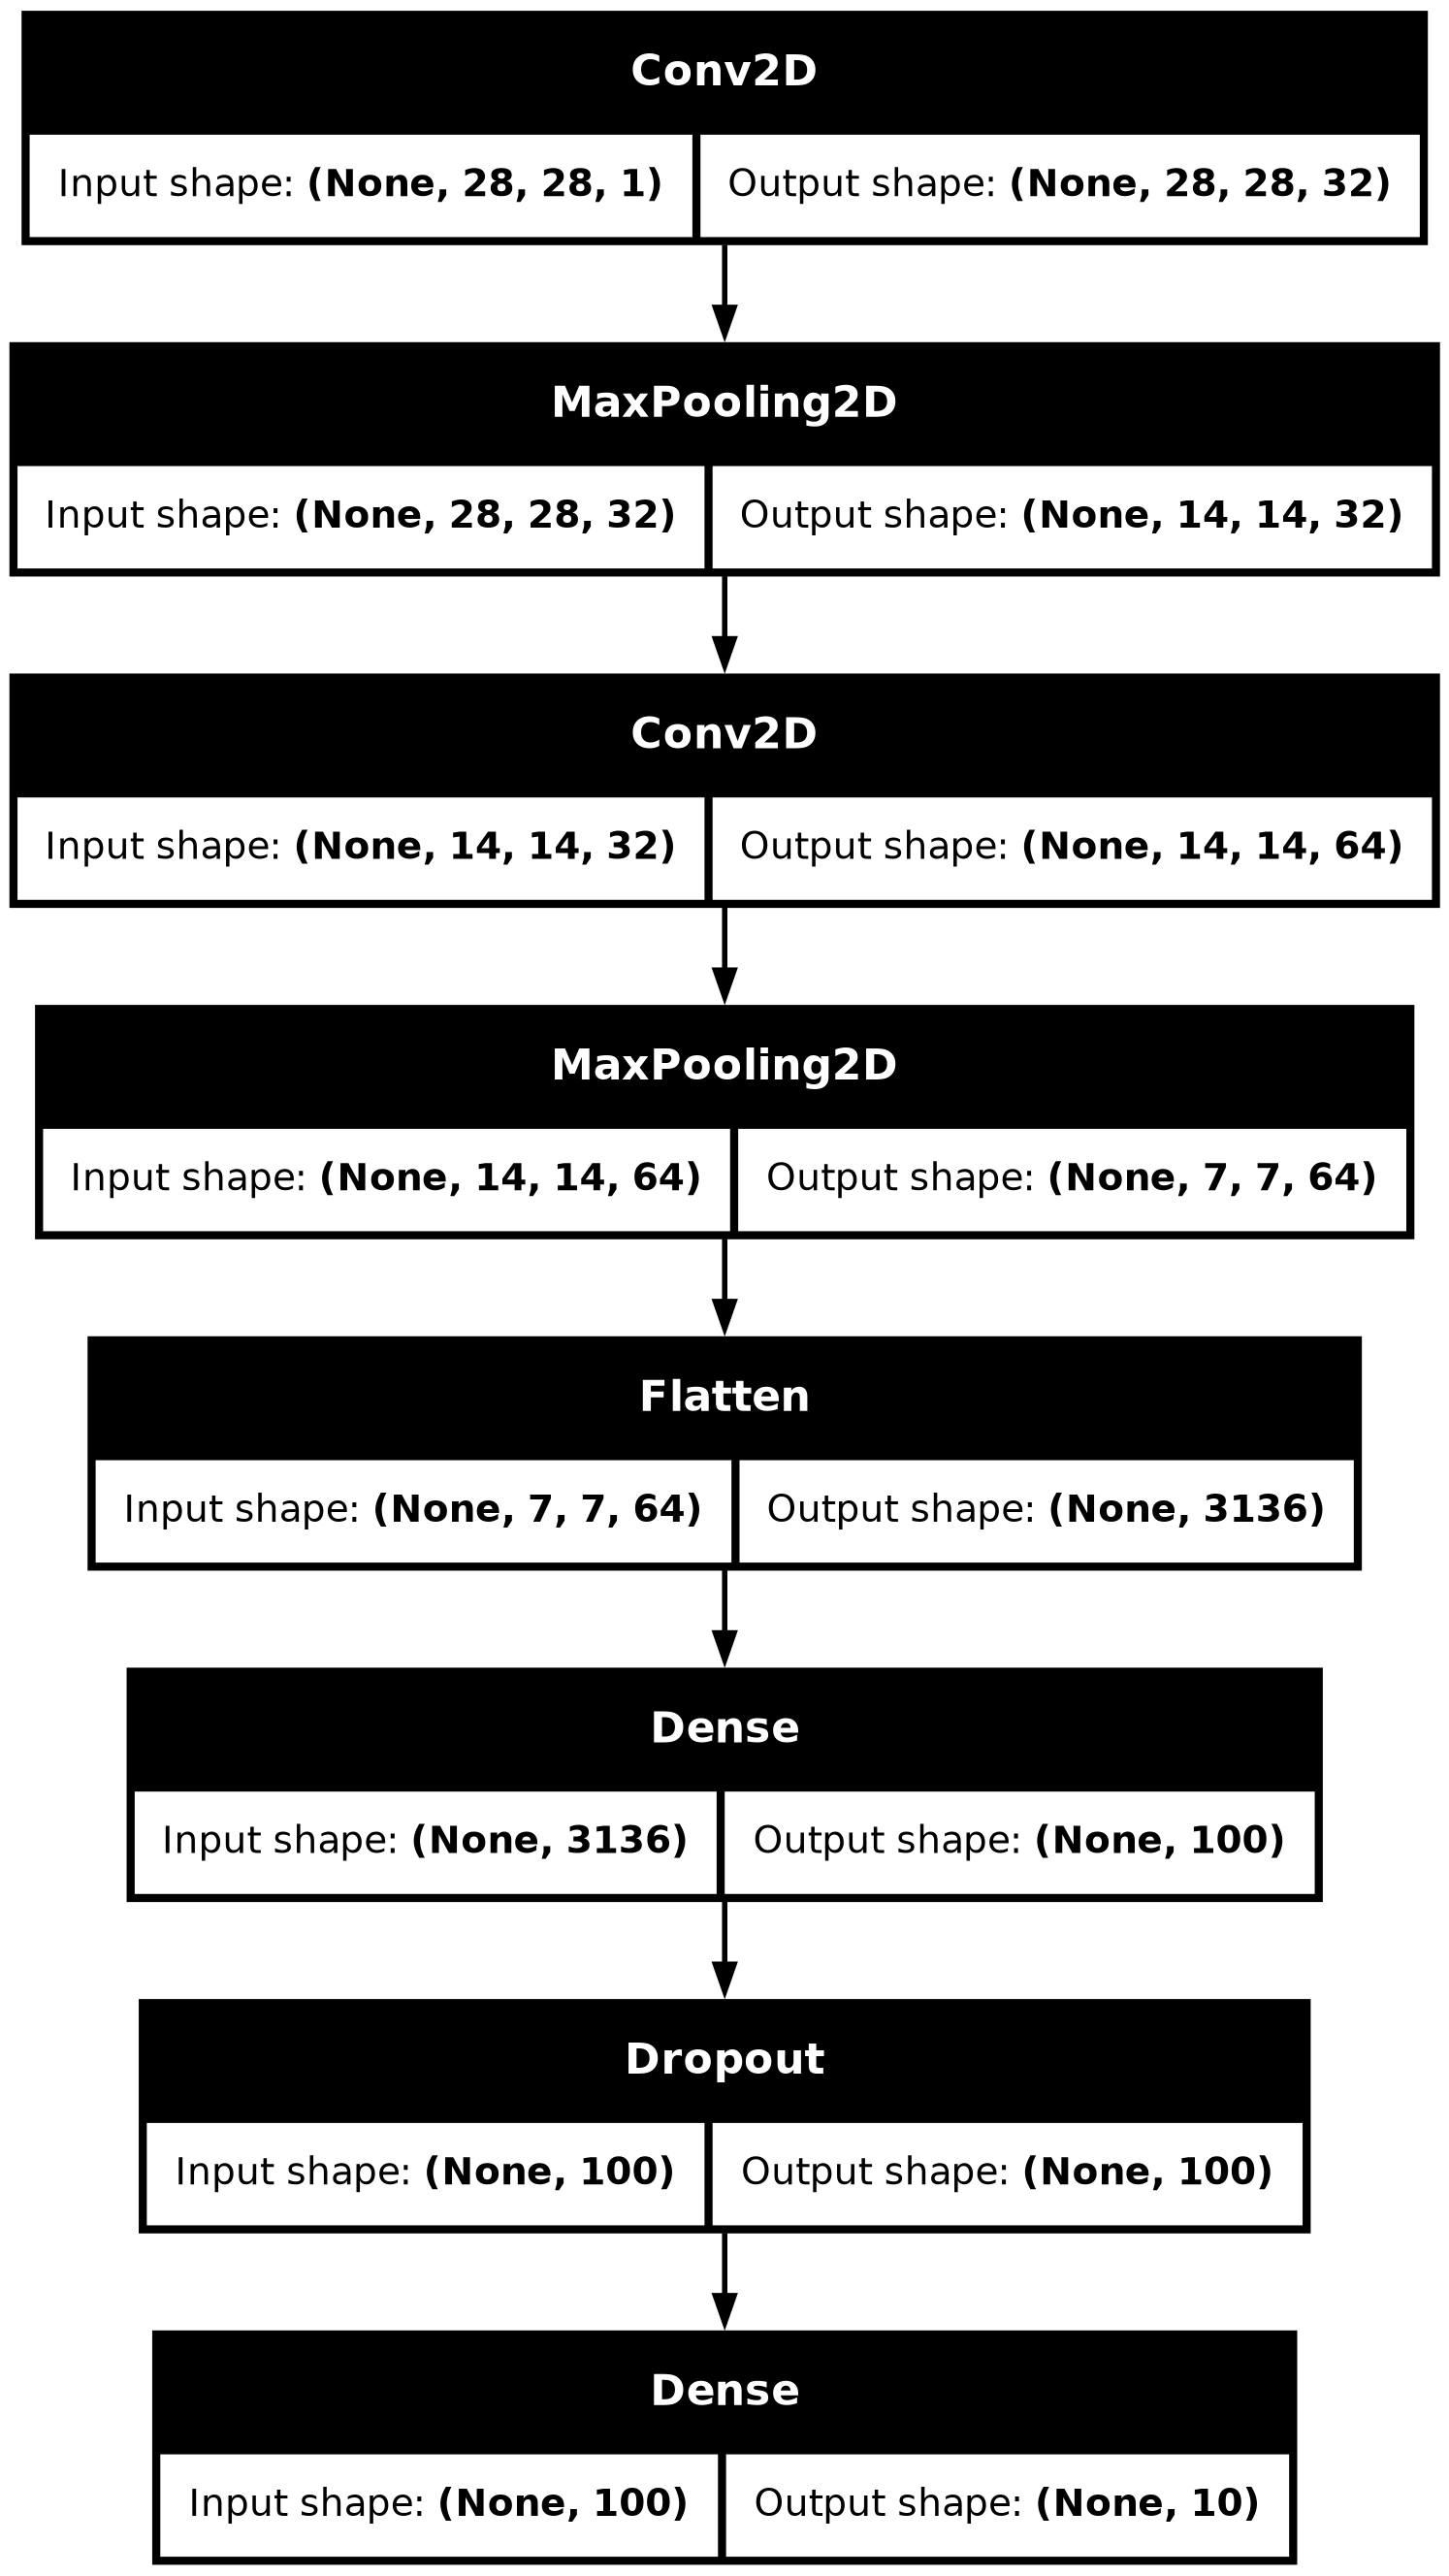

In [12]:
# 층별 모델 & 입출력 형태 확인
keras.utils.plot_model(model, show_shapes=True)

In [13]:
# adam 옵티마이저, 다중분류 손실함수 모델링 20 에포크, 조기중단조건 2
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'], jit_compile=False)
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-cnn-model.keras', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)
history = model.fit(train_scaled, train_target, epochs=20,
                    validation_data=(val_scaled, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.7405 - loss: 0.7251 - val_accuracy: 0.8793 - val_loss: 0.3317
Epoch 2/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - accuracy: 0.8682 - loss: 0.3662 - val_accuracy: 0.8967 - val_loss: 0.2808
Epoch 3/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.8864 - loss: 0.3087 - val_accuracy: 0.9035 - val_loss: 0.2615
Epoch 4/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - accuracy: 0.8989 - loss: 0.2744 - val_accuracy: 0.9107 - val_loss: 0.2479
Epoch 5/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - accuracy: 0.9072 - loss: 0.2538 - val_accuracy: 0.9145 - val_loss: 0.2370
Epoch 6/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - accuracy: 0.9148 - loss: 0.2284 - val_accuracy: 0.9170 - val_loss: 0.2296
Epoch 7/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - accuracy: 0.9209 - loss: 0.2144 - val_accuracy: 0.9163 - val_loss: 0.2404
Epoch 8/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - accuracy: 0.9266 -

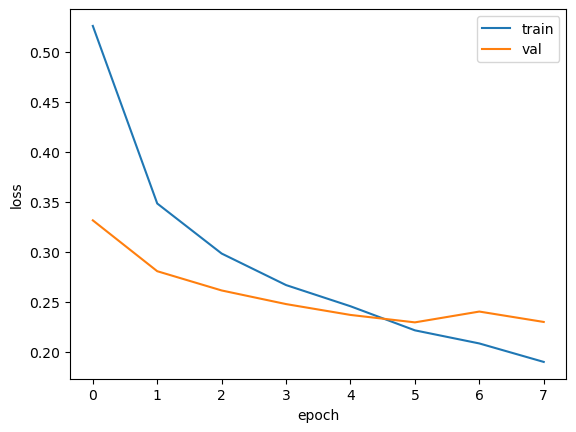

In [14]:
# 훈련 & 검증 손실 그래프
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

In [15]:
# 검증 세트 수치 확인
model.evaluate(val_scaled, val_target)

375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9192 - loss: 0.2238


[0.2295893132686615, 0.9169999957084656]

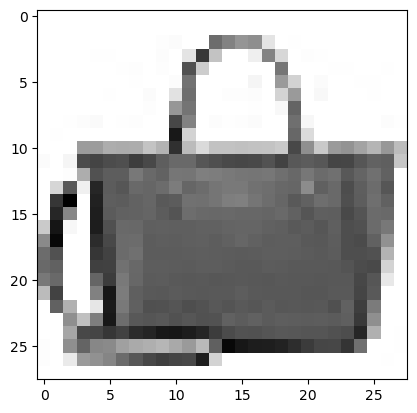

In [16]:
# 샘플 확인
plt.imshow(val_scaled[0].reshape(28, 28), cmap='gray_r')
plt.show()

In [17]:
# 샘플 예측 확인
preds = model.predict(val_scaled[0:1])
print(preds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
[[6.1813571e-21 3.4862483e-28 9.4859249e-23 1.3872111e-19 7.8794653e-20
  1.0321981e-19 1.5550004e-21 2.0156025e-19 1.0000000e+00 4.0918977e-21]]


2025-12-16 16:56:25.452756: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


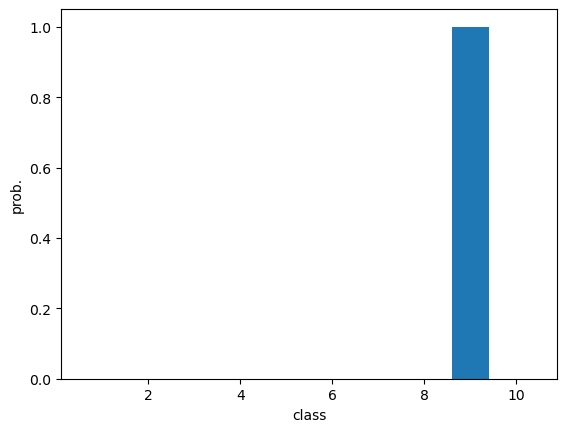

In [18]:
# 샘플의 클래스별 확률 그래프
plt.bar(range(1, 11), preds[0])
plt.xlabel('class')
plt.ylabel('prob.')
plt.show()

In [ ]:
# 예측값에 따른 클래스 확인
classes = ['티셔츠', '바지', '스웨터', '드레스', '코트', '샌달', '셔츠', '스니커즈', '가방', '앵클 부츠']
print(classes[np.argmax(preds)])

가방


In [20]:
# 테스트 세트로 성능 검증
test_scaled = test_input.reshape(-1, 28, 28, 1) / 255.0 # 스케일링
model.evaluate(test_scaled, test_target)

  9/313 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9086 - loss: 0.3427   

2025-12-16 17:01:42.673276: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9096 - loss: 0.2624


[0.25302058458328247, 0.9110000133514404]